### Práctico Aprendizaje no Supervisado

Este último práctico tiene dos objetivos. El primero de ellos está vinculado a mejorar los modelos predictivos desarrollados en los prácticos anteriores empleando herramientas propias del aprendizaje no supervisado. El segundo consiste en emplear este tipo de herramientas para analizar los datos desde un punto de vista diferente al que vinimos haciendo hasta ahora. 

#### Problema 1

- Embeddings: Utilicen Principal Component Analysis para reducir la dimensionalidad del dataset. Partan del dataset curado por ustedes, incluyendo tanto los features originales como aquellos que hayan calculado. Apliquen PCA y analicen la varianza explicada en función de la cantidad de dimensiones (grafiquen varianza vs dimensiones). Construyan un nuevo dataset utilizando sólo las dimensiones más explicativas (utilicen el criterio que crean conveniente para decidir el número de diemensiones). Discutan sobre la relación entre las direcciones halladas por el método de embedding y los features originales.
Corran los modelos utilizados en el práctico anterior utilizando el nuevo dataset. Describan las similitudes y diferencias que encuentren en cuanto a poder predictivo, tiempo de cómputo, y underfitting/overfitting. Observación: los resultados de aplicar PCA dependen de si los datos están estandarizados o no. En la mayoría de los casos, es conveniente estandarizar los datos antes de hacer el embedding, pero hay excepciones. Teniendo esto en cuenta, decidan ustedes si realizan o no la estandarización. Pueden ver un poco más sobre estandarización [acá](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).


- Clustering: Utilicen el algoritmo KMeans para detectar clusters en el conjunto de entrenamiento. Para determinar el número de clusters adecuado, empleen el método del codo y/o el método de siluetas (justifiquen su elección). Utilicen la pertenencia a los clusters como un nuevo feature e incorpórenlo al dataset. Pueden guiarse por [este](https://towardsdatascience.com/cluster-then-predict-for-classification-tasks-142fdfdc87d6) artículo. 

#### Problema 2

- Realicen un análisis exploratorio de los datos empleando técnicas de clustering. Elijan un método de clustering y aplíquenlo a los datos. Observen los clusters detectados e intenten dar una interpretación de los mismos. ¿Existen características particulares de cada cluster? ¿Puede servir esta técnica para identificar ciertos "perfiles" de pacientes o de turnos? ¿Hay correlación entre los clusters y alguno de los feature? Repitan utilizando un segundo método y comparen los resultados.
Este problema es más bien exploratorio. Puede ser que encuentren algo interesante, o puede ser que no encuentren nada relevante. Lo importante no es tanto los resultados alcanzados, como el familiarizarse con los distintos algoritmos de clustering.

In [1]:
import numpy as np
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [2]:
dfp = pd.read_csv('turnos_con_paciente_2018-2019_despersonalizado.csv', sep=';')
dfsp = pd.read_csv('turnos_sin_paciente_2018-2019_despersonalizado.csv', sep=';')

In [3]:
## Renombramos columnas
to_rename = {
    'Centro de atención': 'CentroDeAtencion',
    'Prestación asignada': 'Prestacion',
    'Estado del turno': 'EstadoDelTurno',
    'Nombre del canal': 'Canal',
    'Fecha del turno': 'FechaDelTurno',
    'Hora del turno': 'HoraDelTurno',
    'Es sobre turno': 'EsSobreTurno',
    'Tipo de turno asignado': 'TipoDeTurno'
        }
dfsp_r = dfsp.rename(columns=to_rename)

In [4]:
## Parseamos fechas
dfsp_r.FechaDelTurno = dfsp_r.FechaDelTurno + ' ' + dfsp_r.HoraDelTurno
dfsp_r.FechaDelTurno = pd.to_datetime(dfsp_r.FechaDelTurno)
dfsp_r = dfsp_r.drop(columns=['HoraDelTurno'])

In [5]:
## Renombramos columnas
to_rename = {
    'CentroAtencion_Nombre': 'CentroDeAtencion',
    'Servicio_Nombre': 'Servicio',
    'TurnoEstado_Nombre': 'EstadoDelTurno',
    'FechaTurno': 'FechaDelTurno',
    'TipoTurno': 'TipoDeTurno',
    'Dirección (localidad)' : 'Localidad',
    'Dirección (provincia)' : 'Provincia',
    'FechaOtrogado' : 'FechaOtorgado'
    }
dfp_r = dfp.rename(columns=to_rename)

In [6]:
## Renombramos columnas
to_rename = {
    'CentroAtencion_Nombre': 'CentroDeAtencion',
    'Servicio_Nombre': 'Servicio',
    'TurnoEstado_Nombre': 'EstadoDelTurno',
    'FechaTurno': 'FechaDelTurno',
    'TipoTurno': 'TipoDeTurno',
    'Dirección (localidad)' : 'Localidad',
    'Dirección (provincia)' : 'Provincia',
    'FechaOtrogado' : 'FechaOtorgado'
    }
dfp_r = dfp.rename(columns=to_rename)

In [7]:
## Parseamos fechas
dfp_r.FechaDelTurno = pd.to_datetime(dfp_r.FechaDelTurno)

In [8]:
##Hacemos minúscula todo
dfp_r.Localidad = dfp_r.Localidad.str.lower()
dfp_r.Provincia = dfp_r.Provincia.str.lower()

In [9]:
dfp_r.Localidad.replace(['-', ' '], 'No definido', inplace=True)
dfp_r.loc[dfp_r.Localidad.isnull(), 'Localidad'] = 'No definido'
dfp_r.Provincia.replace(['-', ' '], 'No definido', inplace=True)
dfp_r.loc[dfp_r.Provincia.isnull(), 'Provincia'] = 'No definido'

In [10]:
##Reemplazamos todos los _Córdoba_ mal escritos (ya revisados) por "cordoba"
Mal_Escrito = ['cba', 'cordiba', 'cordo', 'cordobacapital', 'cordobacapitral', 'cordonba', 'corodba', 'crdoba', 'ordoba']
dfp_r.Localidad.replace(Mal_Escrito,'cordoba', inplace=True)
dfp_r.Provincia.replace(Mal_Escrito,'cordoba', inplace=True)

In [11]:
#Localidad
##Evaluamos y reemplazamos los que tenemos dudas (ya revisados), por "cordoba" 
Duda = ['capital', 'centro']
dfp_r.loc[(dfp_r.Provincia == 'cordoba') & (dfp_r.Localidad.isin(Duda)), 'Localidad'] = 'cordoba'

In [12]:
#Provincia
##Reemplazamos los posibles "nodefinido" por "cordoba" en Provincia, cuando Localidad='cordoba'
dfp_r.loc[dfp_r.Localidad == 'cordoba', 'Provincia'] = 'cordoba'

In [13]:
##Reemplazamos todo lo que no es "cordoba" por "otro"
dfp_r.loc[(dfp_r.Provincia != 'cordoba') , 'Provincia'] = 'otro'
dfp_r.loc[(dfp_r.Provincia == 'nodefinido'), 'Provincia'] = 'otro'
dfp_r.loc[(dfp_r.Localidad != 'cordoba') , 'Localidad'] = 'otro'
dfp_r.loc[(dfp_r.Localidad == 'nodefinido'), 'Localidad'] = 'otro'

In [14]:
dfp_r.EstadoDelTurno= dfp_r.EstadoDelTurno.replace ({'Atendiendo' :'Atendido','Asignado':'Atendido','Receptado':'Atendido'})

In [15]:
dfsp_r_t= dfsp_r[dfsp_r.EstadoDelTurno.isin (['Atendido','Ausente'])]

In [16]:
dfsp_r_t.TipoDeTurno.unique()

array(['Ulterior / Control', 'Primera Vez', 'Práctica', 'DNP', 'Recetas'],
      dtype=object)

In [17]:
cols = [
    'CentroDeAtencion', 'Servicio', 'Recurso', 'FechaDelTurno', 
    'EstadoDelTurno', 'Prestacion', 'TipoDeTurno'
]
df = dfp_r.merge(dfsp_r_t, on=cols)

In [18]:
df.sample(15)

,CentroDeAtencion,Prestador,Recurso,Servicio,FechaDelTurno,EstadoDelTurno,Sexo,Edad,HC,TipoDeTurno,Prestacion,FechaOtorgado,Localidad,Provincia,Canal,EsSobreTurno
765906,2,PREVENCION SALUD,187,OFTALMOLOGÍA,2019-04-22 13:29:00,Atendido,M,4,125465.0,Ulterior / Control,CONSULTA OFTALMOLOGICA VESTIDA,2019-04-22 13:30:41.283000,otro,otro,NaN,SI
363351,1,SWISS MEDICAL S.A.,301,DERMATOLOGÍA,2018-08-30 10:45:00,Atendido,M,39,46895.0,Ulterior / Control,CONSULTA MEDICA,2018-07-30 19:16:58.867000,otro,otro,Recepción,NO
1123676,1,OSPJTAP,263,CLÍNICA MÉDICA,2019-10-04 16:38:00,Atendido,M,56,138502.0,Ulterior / Control,CONSULTA MEDICA,2019-10-04 15:37:24.713000,otro,cordoba,NaN,SI
625663,3,OMINT S. A. DE SERVICIOS,158,CLÍNICA MÉDICA,2019-01-30 09:00:00,Atendido,F,72,6882.0,Primera Vez,CONSULTA MEDICA,2019-01-29 12:02:49.847000,cordoba,cordoba,Call Center,NO
612638,3,SIPSSA,5,PEDIATRÍA,2019-01-22 09:40:00,Atendido,F,4,45894.0,Primera Vez,CONSULTA MEDICA,2019-01-21 09:28:40.177000,otro,otro,Call Center,NO
1020575,4,PREVENCION A.R.T.,495,TERAPIA OCUPACIONAL,2019-08-23 12:00:00,Atendido,M,55,121810.0,Práctica,TERAPIA OCUPACIONAL,2019-08-15 17:34:29.773000,otro,otro,Recepción,NO
256906,1,OSDE,315,DIABETOLOGIA Y NUTRIC,2018-06-26 18:40:00,Atendido,F,66,24519.0,Ulterior / Control,CONSULTA MEDICA,2018-05-23 09:27:02.623000,otro,cordoba,Call Center,NO
634889,2,MEDIFE ASOCIACIÓN CIVIL,187,OFTALMOLOGÍA,2019-02-05 10:20:00,Atendido,M,7,4354.0,Primera Vez,CONSULTA OFTALMOLOGICA VESTIDA,2019-01-09 11:30:46.560000,cordoba,cordoba,Call Center,NO
933340,2,SANCOR,28,GINECOLOGIA PRACTICAS CP,2019-07-16 08:45:00,Atendido,F,33,33248.0,Práctica,BIOPSIA DE CUELLO UTERINO- ESCISION DE POLIPO ...,2019-06-27 09:27:02.130000,otro,otro,Recepción,NO
544095,4,SWISS MEDICAL S.A.,506,KINESIOL Y FISIOTERAPIA,2018-12-07 13:50:00,Atendido,M,48,96413.0,Práctica,MODULO KINESIO-FISIO + MAGNETO Y/O LASER,2018-11-29 12:34:50.693000,cordoba,cordoba,NaN,NO


In [19]:
df.dtypes

CentroDeAtencion             int64
Prestador                   object
Recurso                      int64
Servicio                    object
FechaDelTurno       datetime64[ns]
EstadoDelTurno              object
Sexo                        object
Edad                         int64
HC                         float64
TipoDeTurno                 object
Prestacion                  object
FechaOtorgado               object
Localidad                   object
Provincia                   object
Canal                       object
EsSobreTurno                object
dtype: object

In [20]:
df.EsSobreTurno.unique()

array(['SI', 'NO'], dtype=object)

In [21]:
df.loc[(df.Canal == 'Teléfono'), 'Canal'] = 'Telefono'

In [22]:
df.loc[(df.Canal == 'Call Center'), 'Canal'] = 'Telefono'

In [23]:
df.dropna( inplace=True )

In [24]:
df.Canal.unique()

array(['Recepción', 'Telefono', 'Turnos Online', 'No Definido',
       'Chat/Redes Sociales'], dtype=object)

In [25]:
df_1= df[df.Sexo.isin (['F','M'])]

In [26]:
df_1.Sexo.unique()

array(['M', 'F'], dtype=object)

In [27]:
df.EsSobreTurno.unique()

array(['NO'], dtype=object)

In [28]:
df_1.HC = df_1.HC.astype(int)

In [29]:
df_1 = df_1.drop(df_1[df_1['Edad'] < 18].index)

In [30]:
df_1 = df_1.drop(df_1[df_1['Edad'] > 100].index)

In [31]:
df_1['FechaOtorgado'] = pd.to_datetime(df.FechaOtorgado)

In [32]:
df_1['FechaDiaDelTurno'] = [d.date() for d in df_1['FechaDelTurno']]
df_1['HoraTurno'] = [d.time() for d in df_1['FechaDelTurno']]

In [33]:
df_1['FechaDiaOtorgado'] = [d.date() for d in df_1['FechaOtorgado']]
df_1['HoraOtorgado'] = [d.time() for d in df_1['FechaOtorgado']]

In [34]:
df_1['DifDias'] = df_1.FechaDiaDelTurno - df_1.FechaDiaOtorgado

In [35]:
x=pd.Timedelta(0,'d')

In [36]:
df_1['AnticipacionDeReserva'] = 1

In [37]:
df_1.loc[(df_1.DifDias == x ), 'AnticipacionDeReserva'] = 0

In [38]:
df_1.AnticipacionDeReserva.value_counts()

1    542324
0     69506
Name: AnticipacionDeReserva, dtype: int64

In [39]:
df_1['DiaTurno'] = df_1['FechaDelTurno'].apply(lambda time: time.dayofweek)
df_1['MesTurno'] = df_1['FechaDelTurno'].apply(lambda time: time.month)
df_1['DiaTurnoNombre'] = df_1['DiaTurno'].apply(lambda x: 'Lunes' if x == 0 else 'Martes' if x == 1
                                 else 'Miercoles' if x == 2 else 'Jueves' if x == 3
                                 else 'Viernes' if x== 4 else 'Sabado' if x == 5
                                 else 'Domingo' )

In [40]:
df_1 = df_1.drop(df_1[df_1['DiaTurnoNombre'] == 'Domingo'].index)

In [41]:
df_1.DiaTurnoNombre.unique()

array(['Martes', 'Miercoles', 'Jueves', 'Viernes', 'Lunes', 'Sabado'],
      dtype=object)

In [42]:
for i in ['REUMATOLOGÍA INF','ENDOCRINOLOGÍA INF',
          'DERMATOLOGÍA INF', 'DIABETOLOGIA Y NUTRIC INF',
          'NEUMONOLOGÍA INF', 'NEFROLOGÍA INF', 'ALERGIA E INMUNOLOGÍA INF',
          'ORTOPEDIA Y TRAUMATO INF','DIABETOLOGIA Y NUTRIC INF',
          'OTORRINOLARINGOLOGIA INF','NEUROLOGÍA INF', 
          'HEMATOLOGÍA INF', 'NUTRICIÓN INFANTIL',
          'CARDIOLOGÍA INF', 'GASTROENTEROLOGÍA INF'
          'DEMANDA DE GASTRO INF', 'INFECTOLOGÍA INF'
          'PSICOLOGÍA INF', 'CIRUGÍA PLÁSTICA INF',
          'CIRUGÍA GENERAL INF', 'UROLOGÍA INF','DEMANDA DE GASTRO INF',
          'FONOAUDIOLOGIA INF', 'NEUROCIRUGÍA INF', 'DEMANDA DE NEUROLOGIA INF',
          'GUARDIA DE TRAUMATO DIA', 'PSICOLOGÍA INF', 'CUIDADOS PALIATIVOS INF',
          'OTORRINOLARINGOLOGIA INF', 'DEMANDA DE PEDIATRÍA', 'INFECTOLOGÍA INF' ,'CUENTAS PROPIAS ALERGIA E INMUNOLOGIA INF',
          'PEDIATRÍA', 'DEMANDA DE ORL INF', 'GASTROENTEROLOGÍA INF', 'TERAPIA OCUPACIONAL INF',
          'GUARDIA DE PEDIATRIA', 'CHEQUEO PEDIATRICO']:
    df_1 = df_1.drop(df_1[df_1['Servicio'] == i].index)

In [43]:
df_1 = df_1.drop(df_1[df_1['CentroDeAtencion'] == 5].index)

In [44]:
df_1 = df_1.drop(df_1[df_1['CentroDeAtencion'] == 6].index)

In [45]:
df_1.CentroDeAtencion.unique()

array([1, 4, 3, 2], dtype=int64)

In [46]:
df_1['ConsultaMedica'] = 0

In [47]:
df_1.loc[(df_1.Prestacion== 'CONSULTA MEDICA' ), 'ConsultaMedica'] = 1

In [48]:
df_1.ConsultaMedica.unique()

array([0, 1], dtype=int64)

In [49]:
df_1['ConsumidorFinal'] = 0

In [50]:
df_1.loc[(df_1.Prestador == 'CONSUMIDOR FINAL' ), 'ConsumidorFinal'] = 1

In [51]:
df_1.ConsumidorFinal.unique()

array([0, 1], dtype=int64)

In [52]:
df_1.isnull().values.any()

False

In [53]:
df_1.isnull().sum().sum()

0

In [54]:
df_1.columns[df_1.isnull().any()]

Index([], dtype='object')

In [55]:
df_1['TipoDeTurnoEncode'] = df_1['TipoDeTurno'].apply(lambda x: 1 if x == 'Práctica' else 2 if x == 'Primera Vez'
                                 else  3 if x == 'Ulterior / Control' else 4 if x == 'DNP'
                                 else 5 )

In [56]:
df_1['EstadoDelTurnoEncode'] = 0

In [57]:
df_1.loc[(df_1.EstadoDelTurno == 'Ausente' ), 'EstadoDelTurnoEncode'] = 1

In [58]:
df_1['SexoEncode'] = 0

In [59]:
df_1.loc[(df_1.Sexo == 'F' ), 'SexoEncode'] = 1

In [60]:
df_1.loc[(df_1.Sexo == 'M' ), 'SexoEncode'] = 0

In [61]:
df_1['STEncode'] = 0

In [62]:
df_1.loc[(df_1.EsSobreTurno == 'NO' ), 'STEncode'] = 1

In [63]:
df_clima2018 = pd.read_csv('clima_2018.csv')
df_clima2019 = pd.read_csv('clima_2019.csv')

In [64]:
df_clima = pd.concat([df_clima2018, df_clima2019], ignore_index=True, sort=False)

In [65]:
to_rename = {
    'Fecha' : 'FechaDiaDelTurno' ,
    'Hr.Med(%)': 'HrMedPorcentaje',
    'Prec.(mm)': 'PrecipMM',
    'Pres.n. mar(Hp)': 'PresionHp',
    'TdMed(C)': 'TempMedCentigrados',
    'Dir.': 'Direccion',
    'Rch.': 'Rch',
    'Vel.': 'Vel',
            }
df_clima_r = df_clima.rename(columns=to_rename)

In [66]:
df_clima_r= df_clima_r.drop(['HrMedPorcentaje', 'NubTotOct', 'NubbajOct', 'PresionHp', 
             'TempMedCentigrados', 'Tmax', 'Tmed', 'Tmin', 'Direccion', 
             'Rch', 'Vel', 'VisKm'], axis=1)

In [67]:
df_clima_r['FechaDiaDelTurno'] = pd.to_datetime(df_clima_r.FechaDiaDelTurno)

In [68]:
df_1['FechaDiaDelTurno'] = pd.to_datetime(df_1.FechaDiaDelTurno)

In [69]:
df_1_1= df_clima_r.merge(df_1, on=['FechaDiaDelTurno'])
df_1_1.head()

,FechaDiaDelTurno,PrecipMM,CentroDeAtencion,Prestador,Recurso,Servicio,FechaDelTurno,EstadoDelTurno,Sexo,Edad,...,AnticipacionDeReserva,DiaTurno,MesTurno,DiaTurnoNombre,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,EstadoDelTurnoEncode,SexoEncode,STEncode
0,2018-02-01,0.0,1,GALENO ARGENTINA SA,290,HEMATOLOGIA PRACTICAS,2018-02-01 08:00:00,Atendido,F,35,...,1,3,2,Jueves,0,0,1,0,1,1
1,2018-02-01,0.0,1,D.A.S.U.T.E.N.,470,NUTRICIÓN,2018-02-01 08:00:00,Atendido,F,33,...,1,3,2,Jueves,0,0,1,0,1,1
2,2018-02-01,0.0,1,SANCOR,505,GASTROENTEROLOGÍA,2018-02-01 08:00:00,Atendido,M,32,...,1,3,2,Jueves,1,0,3,0,0,1
3,2018-02-01,0.0,1,OSDE,145,GINECOLOGIA PRACTICAS CP,2018-02-01 08:00:00,Ausente,F,24,...,1,3,2,Jueves,0,0,1,1,1,1
4,2018-02-01,0.0,1,PERSONAL DE FARMACIA-GAPRESA,274,CARDIOLOGÍA,2018-02-01 08:00:00,Atendido,M,55,...,1,3,2,Jueves,0,0,1,0,0,1


In [70]:
dataset = df_1_1.select_dtypes(include=[np.number])

In [71]:
dataset['DifDias']= dataset['DifDias']/ np.timedelta64(1, 'D')

In [72]:
dataset.insert(0,'EstadoDelTurno',dataset.EstadoDelTurnoEncode)

In [73]:
dataset = dataset.drop(columns=['EstadoDelTurnoEncode'])

In [74]:
dataset = dataset.drop(columns=['STEncode'])

In [75]:
# dataset = dataset.drop(columns=['HC'])

In [76]:
dataset = dataset.drop(columns=['DifDias'])

In [77]:
dataset.dtypes

EstadoDelTurno           int64
CentroDeAtencion         int64
Recurso                  int64
Edad                     int64
HC                       int32
AnticipacionDeReserva    int64
DiaTurno                 int64
MesTurno                 int64
ConsultaMedica           int64
ConsumidorFinal          int64
TipoDeTurnoEncode        int64
SexoEncode               int64
dtype: object

In [78]:
duplicados= dataset[dataset.duplicated(keep=False)]

In [79]:
duplicados.sort_values(by=['EstadoDelTurno', 'CentroDeAtencion', 'Recurso', 'Edad',
       'AnticipacionDeReserva', 'DiaTurno', 'MesTurno', 'ConsultaMedica',
       'ConsumidorFinal', 'TipoDeTurnoEncode', 'SexoEncode'])

,EstadoDelTurno,CentroDeAtencion,Recurso,Edad,HC,AnticipacionDeReserva,DiaTurno,MesTurno,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,SexoEncode
125022,0,1,2,20,19373,1,3,6,1,0,3,1
391180,0,1,2,20,19373,1,3,6,1,0,3,1
56751,0,1,2,22,18575,1,2,4,1,0,3,1
338766,0,1,2,22,18575,1,2,4,1,0,3,1
110064,0,1,2,24,5409,1,3,6,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
168494,1,4,506,40,29032,0,4,3,0,0,1,1
90527,1,4,506,50,28658,1,5,5,0,0,1,0
235631,1,4,506,50,28658,1,5,5,0,0,1,0
29513,1,4,506,52,21413,1,2,2,0,0,1,1


In [80]:
dataset.drop_duplicates(inplace=True)

# Modelos Aprendizaje No supervisado

# Librerias

In [81]:
from sklearn import (manifold, decomposition)
import time
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cluster import KMeans,MeanShift,estimate_bandwidth
from sklearn import decomposition
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Visualizacion-con-embeddings:tSNE

**t-SNE : t-distributed Stochastic Neighbor Embedding.**

t-SNE es una herramienta para visualizar datos altamente dimensionales. 

Los "proyecta" en menos dimensiones (2D o 3D) manteniendo la distancia entre ellos.

Comienza convirtiendo distancias entre puntos (observaciones) en probabilidades condicionales. 

Y luego va acomodando puntos asociados (en el plano 2D o el espacio 2D) que "ajusten" las probabilidades condicionales.

El ajuste consiste en minimizar la divergencia the Kullback-Leibler entre las probabilidades condicionales establecidas en el espacio de mayor dimension y las determinadas en el espacio de menor dimension. 

El modelo de distribución de probabilidad es el de t-Student 

t-SNE tiene una función de costo que no es convexa, por lo cual diferentes inicializaciones pueden dar diferentes resultados.

In [82]:
df=dataset.copy()

In [83]:
n_sne=10000 #elegir numero pequeño para agilidad en el cálculo luego
df_sne=df.loc[:n_sne]

X=df_sne
print('dimensión del espacio de los datos: ', len(X))

dimensión del espacio de los datos:  9937


In [84]:
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000)  # Numero de componentes para t-SNE = 2
X_tsne = tsne.fit_transform(X)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9937 samples in 0.576s...
[t-SNE] Computed neighbors for 9937 samples in 0.905s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9937
[t-SNE] Computed conditional probabilities for sample 2000 / 9937
[t-SNE] Computed conditional probabilities for sample 3000 / 9937
[t-SNE] Computed conditional probabilities for sample 4000 / 9937
[t-SNE] Computed conditional probabilities for sample 5000 / 9937
[t-SNE] Computed conditional probabilities for sample 6000 / 9937
[t-SNE] Computed conditional probabilities for sample 7000 / 9937
[t-SNE] Computed conditional probabilities for sample 8000 / 9937
[t-SNE] Computed conditional probabilities for sample 9000 / 9937
[t-SNE] Computed conditional probabilities for sample 9937 / 9937
[t-SNE] Mean sigma: 21.868326
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.322174
[t-SNE] KL divergence after 1000 iterations: 0.557748
t-SNE done! Time elapsed: 78.69579815

In [85]:
data=[]

#graficamos los datos en el espacio transformado: las dos componentes tsne

graf1 = go.Scatter(x=X_tsne[:,0], y=X_tsne[:,1],
                           mode='markers',
                        text=df_sne.loc[:,'TipoDeTurnoEncode'], 
                           marker=dict(
                                size=5)
                           )

graf2 =go.Scatter(x=X_tsne[:,0], y=X_tsne[:,1],
                      text=df_sne.loc[:,'Recurso'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[graf1,graf2]

layout = go.Layout(title="Visualización de la base en el espacio tsne",titlefont=dict(size=20),
                xaxis=dict(title='componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

#iplot(fig)
plot(fig)

'temp-plot.html'

**INTERPRETACIÓN**

Análisis visual supervisado usando tsne creemos que los pacientes se agrupan en el espacio de las variable Tipo de Turno y Recurso

# Componentes-Principales 

In [86]:
n_acp=20000
df_acp=df.loc[:n_acp] 

In [87]:
X=df_acp
print('los datos tienen dimesión n= ',len(X))

los datos tienen dimesión n=  19703


**Se computan las componentes principales**

-cuando se usa *decomposition.PCA* : 

La descomposición PCA del sklearn centra los datos pero no los normaliza (input data is centered but not scaled for each feature before applying the SVD)

por eso **estandarizamos primero**

In [88]:
std_scale=preprocessing.StandardScaler().fit(X)
X_scaled=std_scale.transform(X) # numpyarray normalizado por columna

**DESCOMPOSICIÓN PCA**

En la descomposición podemos elegir n_components para quedarnos con una cantidad chica de componentes 

la idea es que sean "bastante" menos que la dimensión de lo datos pero 

que describan un buen porcentaje de la dispersión de los datos

In [89]:
pca=decomposition.PCA(n_components=4) #elegimos 2, 3 o 4 pero pueden ser más, 

pca.fit(X_scaled) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())
pcaratio = pca.explained_variance_ratio_
X_projected=pca.transform(X_scaled) #numpy array
print ('tamaño de los datos: ', X_projected.shape)

proporción de varianza por componente:  [0.16090141 0.13762219 0.10385674 0.0918244 ]
proporción de varianza por componente acumulada:  [0.16090141 0.29852359 0.40238034 0.49420474]
tamaño de los datos:  (19703, 4)


In [90]:
componentes=[0,1,2,3]

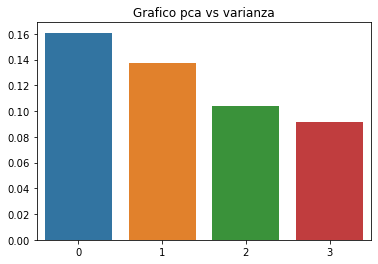

In [91]:
sn.barplot(x=componentes, y=pcaratio)
plt.title('Grafico pca vs varianza')
plt.show()

In [92]:
pcs=pca.components_
#Graph 1
data=[]

for i, (x,y) in enumerate(zip(pcs[0,:],pcs[1,:])):
    graph=go.Scatter(x=[0,x],y=[0,y],text=X.columns[i],
                     mode='lines+markers+text',textposition='top left',textfont=dict(family='sans serif',size=20))
    data.append(graph)

layout = go.Layout(title="Ausentismo",titlefont=dict(size=30),
            xaxis=dict(title='Componente 1'),
            yaxis=dict(title='Componente 2'),
            autosize=False, width=1050,height=750,
            showlegend=False)

fig = go.Figure(data=data, layout=layout)

plot(fig)

'temp-plot.html'

In [93]:
pcs=pca.components_
#Graph 2
data=[]

for i, (x,y) in enumerate(zip(pcs[2,:],pcs[3,:])):
    graph=go.Scatter(x=[0,x],y=[0,y],text=X.columns[i],
                     mode='lines+markers+text',textposition='top left',textfont=dict(family='sans serif',size=20))
    data.append(graph)

layout = go.Layout(title="Ausentismo",titlefont=dict(size=30),
            xaxis=dict(title='Componente 1'),
            yaxis=dict(title='Componente 2'),
            autosize=False, width=1050,height=750,
            showlegend=False)

fig = go.Figure(data=data, layout=layout)

plot(fig)

'temp-plot.html'

**Podemos analizar con el presente gráfico que aquellas features que tienen la misma orientación o bien se dan juntas o bien estan relacionadas en sus características. Como por ejemplo estado del turno y recurso, también la consulta médica con el tipo de turno**

# Clustering

In [94]:
X=df_acp # Datos sin estandarizar
X_scaled=std_scale.transform(X) # normalizar 

In [95]:
# Número de clusters buscado
n_clust = 6

km = KMeans(n_clusters=n_clust, random_state= 0)
km.fit(X_scaled)

# Recuperacion de etiquetas
clusters = km.labels_
print('Etiquetas de los  Cluster: ', clusters)
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km.inertia_)

Etiquetas de los  Cluster:  [1 1 5 ... 2 5 0]
Suma de los cuadrados de las distancias al cluster / Inertia:  143175.41024067168


Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

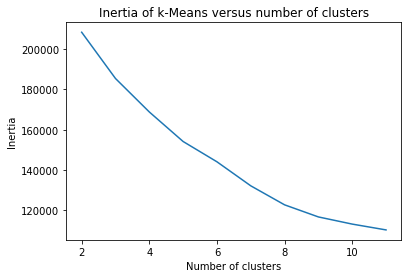

In [96]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i+2).fit(X_scaled).inertia_ for i in range(10)]
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

# Silhouette

El análisis de silueta se puede utilizar para estudiar la distancia de separación entre los grupos resultantes. El gráfico de silueta muestra una medida de qué tan cerca está cada punto en un grupo de puntos en los grupos vecinos y, por lo tanto, proporciona una forma de evaluar parámetros como el número de grupos visualmente

Los coeficientes de silueta (como se denominan estos valores) cercanos a +1 indican que la muestra está lejos de los conglomerados vecinos. Un valor de 0 indica que la muestra está en o muy cerca del límite de decisión entre dos conglomerados vecinos y los valores negativos indican que esas muestras podrían haber sido asignadas al conglomerado incorrecto.

For n_clusters = 2 The average silhouette_score is : 0.7757679900139387
For n_clusters = 3 The average silhouette_score is : 0.5596839355964489
For n_clusters = 4 The average silhouette_score is : 0.6147623103959845
For n_clusters = 5 The average silhouette_score is : 0.6220840732075309
For n_clusters = 6 The average silhouette_score is : 0.5863230529298825


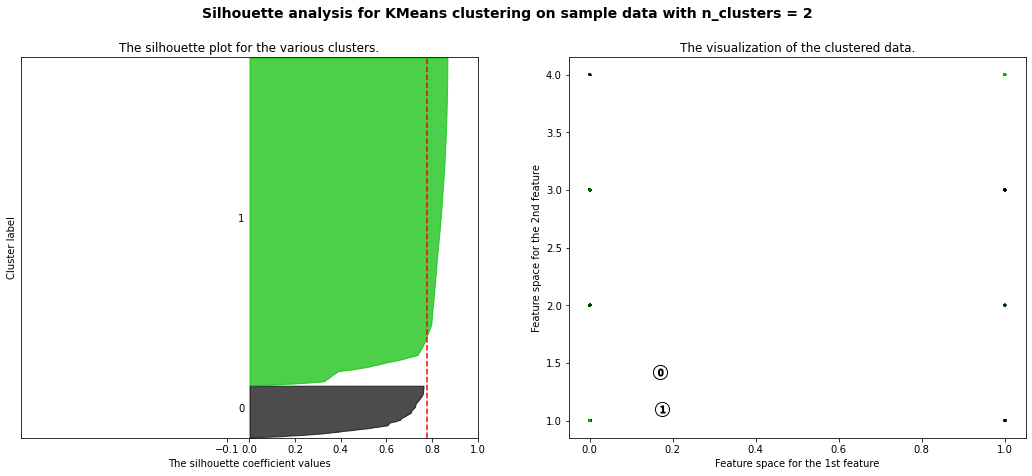

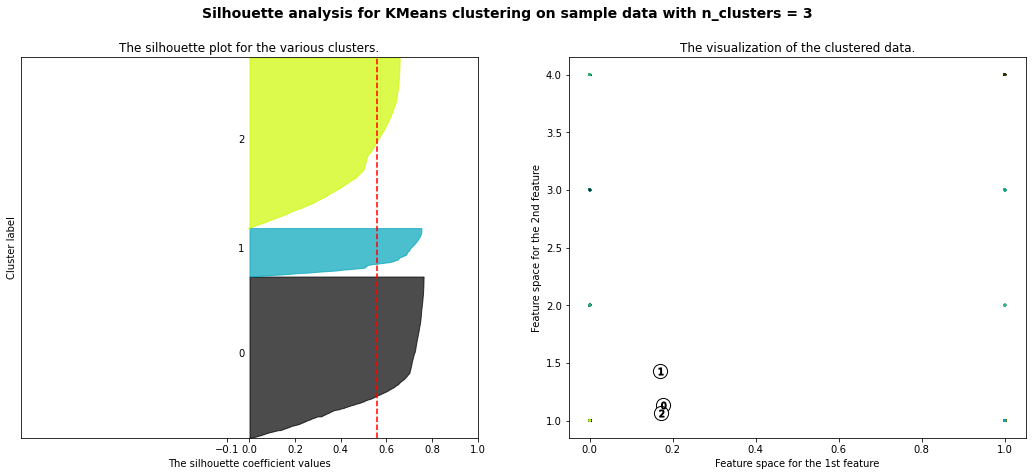

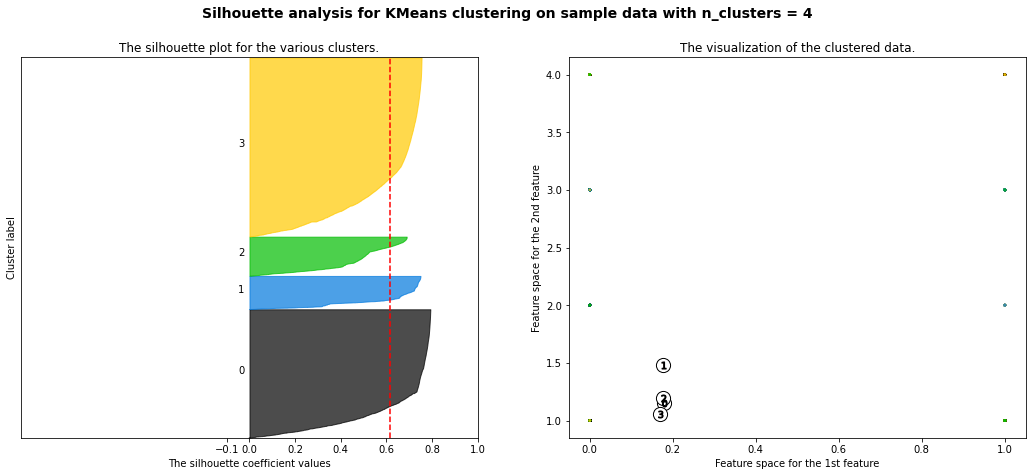

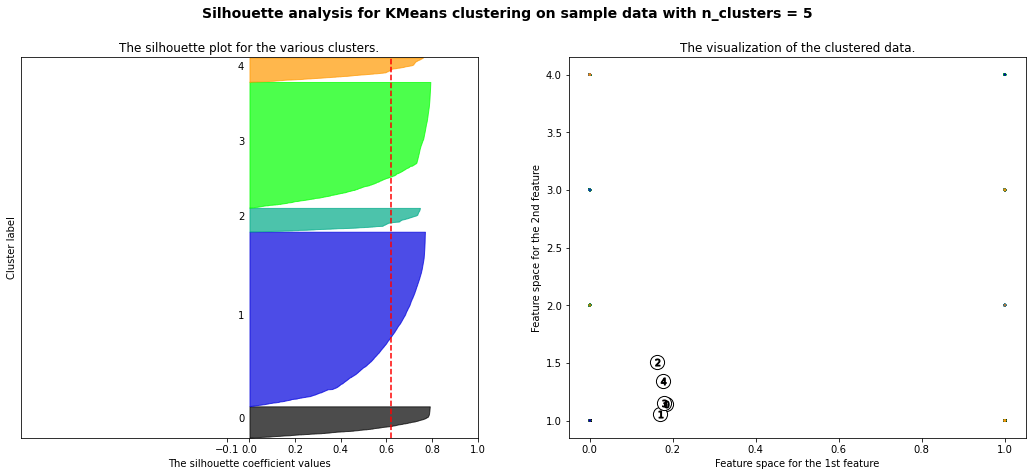

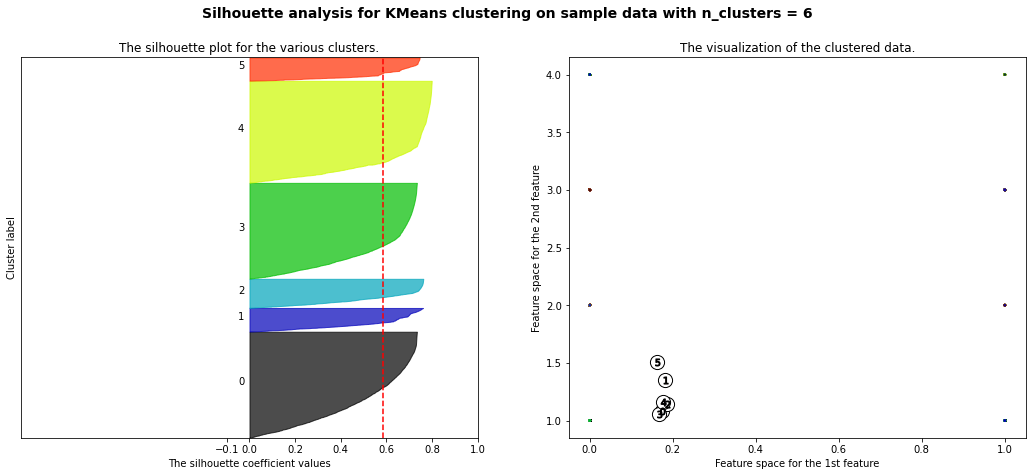

In [97]:
range_n_clusters = [2,3,4,5,6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax1.set_xlim([-1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    
    ax1.set_ylim([0, len(df_acp) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10 )
    cluster_labels = clusterer.fit_predict(df_acp)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_acp, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_acp, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df_acp.iloc[:, 0], df_acp.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

**Observamos que en 6 clusters estan más homogeneos la cantidad por cada cluster**

In [98]:
df_clusters=df_acp.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_) + 1 , 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  6 clusters, nosotros forzamos la cantidad


In [99]:
df_clusters[['HC','kmeans']].groupby('kmeans').agg(['count'])

,HC
,count
kmeans,
0,8086
1,2715
2,1245
3,2632
4,1572
5,3453


In [100]:
df_clusters.loc[(df_clusters.kmeans==0)].sample(15)
# aparentemente consumidor final 0 centro de atención 1 y 3

,EstadoDelTurno,CentroDeAtencion,Recurso,Edad,HC,AnticipacionDeReserva,DiaTurno,MesTurno,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,SexoEncode,kmeans
6570,0,1,9,35,125,1,0,1,1,0,3,1,0
233,0,1,52,36,24361,1,3,2,1,0,3,1,0
7600,0,1,94,45,14805,1,2,1,1,0,2,1,0
6628,0,1,227,51,442,1,1,1,0,0,3,1,0
9770,0,1,362,37,17552,1,4,1,1,0,3,1,0
2110,1,1,515,61,6779,1,4,6,1,0,3,1,0
16202,0,1,333,77,18599,1,2,1,1,0,3,1,0
7410,0,1,48,61,8456,1,1,1,1,0,3,1,0
17265,0,1,14,41,1033,1,1,1,0,0,3,1,0
11113,0,1,14,22,18623,1,1,1,0,0,3,1,0


In [101]:
df_clusters.loc[(df_clusters.kmeans==0)][['CentroDeAtencion','ConsumidorFinal']].groupby(['CentroDeAtencion']).agg(['count'])

,ConsumidorFinal
,count
CentroDeAtencion,
1,8074
3,12


In [102]:
df_clusters.loc[(df_clusters.kmeans==1)].sample(15)
# aparentemente consumidor final mayoría 1 centro de atención 1, 2, 3 , 4

,EstadoDelTurno,CentroDeAtencion,Recurso,Edad,HC,AnticipacionDeReserva,DiaTurno,MesTurno,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,SexoEncode,kmeans
11092,0,1,91,45,5335,1,1,1,0,0,1,1,1
9250,0,1,526,55,13271,1,4,1,0,0,1,0,1
3356,0,1,520,32,36408,1,2,8,0,0,2,1,1
11511,1,1,367,34,4964,1,1,1,0,0,1,0,1
226,0,1,224,80,24354,1,3,2,0,0,1,0,1
730,0,4,506,25,17577,1,3,3,0,0,1,1,1
8827,0,1,57,33,9768,1,3,1,0,0,1,1,1
1964,0,4,508,72,56340,1,4,6,0,1,1,1,1
14342,0,1,185,41,10418,1,0,1,0,0,2,1,1
9605,0,1,526,32,17125,1,4,1,0,0,1,1,1


In [103]:
df_clusters.loc[(df_clusters.kmeans==1)][['CentroDeAtencion','ConsumidorFinal']].groupby(['CentroDeAtencion']).agg(['count'])

,ConsumidorFinal
,count
CentroDeAtencion,
1,2411
2,13
3,26
4,265


In [106]:
df_clusters.loc[(df_clusters.kmeans==2)].sample(15)
# aparentmente consumidor final 0 Centro de Atencion 1 ,2,3,4

,EstadoDelTurno,CentroDeAtencion,Recurso,Edad,HC,AnticipacionDeReserva,DiaTurno,MesTurno,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,SexoEncode,kmeans
13170,0,1,415,71,3379,0,3,1,1,0,3,1,2
11471,0,4,213,47,12903,0,1,1,0,0,1,0,2
17699,0,1,419,25,2338,0,1,1,1,0,3,0,2
11481,0,1,360,20,8764,0,1,1,1,0,2,1,2
19052,0,1,437,72,37214,0,4,3,1,1,3,0,2
11764,0,1,274,80,2228,0,2,1,0,0,1,0,2
9790,0,1,301,23,17579,0,4,1,1,0,2,1,2
8790,0,1,49,32,16340,0,3,1,1,0,2,1,2
18098,0,1,94,34,24536,0,4,2,0,0,2,0,2
11205,0,1,318,74,3794,0,1,1,0,0,3,0,2


In [107]:
df_clusters.loc[(df_clusters.kmeans==2)][['CentroDeAtencion','ConsumidorFinal']].groupby(['CentroDeAtencion']).agg(['count'])

,ConsumidorFinal
,count
CentroDeAtencion,
1,991
2,11
3,56
4,187


In [108]:
df_clusters.loc[(df_clusters.kmeans==3)].sample(15)
# aparentmente consumidor final 0 centro de atención 1,2,3,4

,EstadoDelTurno,CentroDeAtencion,Recurso,Edad,HC,AnticipacionDeReserva,DiaTurno,MesTurno,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,SexoEncode,kmeans
2367,0,1,505,47,80892,1,2,8,1,0,3,0,3
4409,0,3,458,40,78932,1,0,10,1,0,2,1,3
3463,1,1,263,33,63995,1,5,9,1,0,3,0,3
5304,0,1,47,32,54685,1,3,11,1,0,3,1,3
4910,0,1,234,38,83478,1,3,11,0,0,1,0,3
3527,0,1,328,25,93887,1,0,10,1,0,2,1,3
3411,0,3,376,44,81469,1,2,8,1,0,3,0,3
5096,0,2,457,46,101142,1,3,11,0,0,2,1,3
5444,0,3,144,35,68668,1,3,11,1,0,3,1,3
5270,0,1,460,44,101258,1,3,11,1,0,3,0,3


In [109]:
df_clusters.loc[(df_clusters.kmeans==3)][['CentroDeAtencion','ConsumidorFinal']].groupby(['CentroDeAtencion']).agg(['count'])

,ConsumidorFinal
,count
CentroDeAtencion,
1,2004
2,108
3,485
4,35


In [110]:
df_clusters.loc[(df_clusters.kmeans==4)].sample(15)
# aparentmente consumidor final 0 centro de atención 1

,EstadoDelTurno,CentroDeAtencion,Recurso,Edad,HC,AnticipacionDeReserva,DiaTurno,MesTurno,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,SexoEncode,kmeans
11513,0,1,17,37,14845,1,1,1,1,1,3,0,4
10663,0,1,471,66,18921,1,0,1,1,1,3,1,4
3213,0,1,471,66,48767,1,2,8,1,1,3,1,4
16864,0,1,117,28,23887,1,2,1,1,1,3,1,4
12271,0,1,471,91,2691,1,2,1,1,1,3,1,4
9528,0,1,17,36,9232,1,4,1,1,1,2,1,4
16665,0,1,302,54,23730,1,2,1,1,1,2,1,4
12881,0,1,17,36,7772,1,3,1,1,1,3,1,4
1025,0,1,288,46,36759,1,3,3,1,1,3,1,4
12284,0,1,18,38,14802,1,2,1,1,1,3,1,4


In [111]:
df_clusters.loc[(df_clusters.kmeans==4)][['CentroDeAtencion','ConsumidorFinal']].groupby(['CentroDeAtencion']).agg(['count'])

,ConsumidorFinal
,count
CentroDeAtencion,
1,1555
2,3
3,11
4,3


In [112]:
df_clusters.loc[(df_clusters.kmeans==5)].sample(15)
# aparentmente consumidor final 0 centro de atención 1

,EstadoDelTurno,CentroDeAtencion,Recurso,Edad,HC,AnticipacionDeReserva,DiaTurno,MesTurno,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,SexoEncode,kmeans
12854,1,1,300,35,1966,1,3,1,1,0,3,0,5
5252,0,1,459,30,4965,1,3,11,1,0,3,0,5
4657,0,1,250,49,5695,1,0,10,1,0,3,0,5
10919,1,1,504,23,11573,1,1,1,1,0,3,0,5
367,0,1,55,37,2323,1,3,2,1,0,2,0,5
11038,1,1,343,93,17027,1,1,1,1,0,3,0,5
5747,1,1,365,48,4538,1,3,11,1,0,3,0,5
16372,0,1,250,20,23469,1,2,1,1,0,3,0,5
871,0,1,54,37,36464,1,3,3,1,0,2,0,5
1816,1,1,339,74,14094,1,4,6,1,0,3,0,5


In [113]:
df_clusters.loc[(df_clusters.kmeans==5)][['CentroDeAtencion','ConsumidorFinal']].groupby(['CentroDeAtencion']).agg(['count'])

,ConsumidorFinal
,count
CentroDeAtencion,
1,3441
2,5
3,7


**Meanshift**

In [114]:
X=df_acp # Datos sin estandarizar
X_scaled=std_scale.transform(X) # normalizar

In [115]:
#bandwidth_ = estimate_bandwidth(X, quantile=0.20, n_samples=50000)
#ms = MeanShift(bandwidth=bandwidth_ , n_jobs=-1, bin_seeding=True) 
ms = MeanShift(n_jobs=-1, bin_seeding=True) 

ms.fit(df_acp)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero estimado de clusters para Mean Shift : %d" % n_clusters_)

# Etquetas de los elementos de los clusters

Numero estimado de clusters para Mean Shift : 3


In [116]:
data=[]

MeanShift_clusters = go.Scatter(x=df_acp.iloc[:,1], y=df_acp.iloc[:,2],
                           mode='markers',
                        text=df_acp.loc[:,'CentroDeAtencion'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

acp_reserva =go.Scatter(x=df_acp.iloc[:,1], y=df_acp.iloc[:,2],
                      text=df_acp.loc[:,'Recurso'],
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,acp_reserva]

layout = go.Layout(title="ACP + Clustering Mean Shift ",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='Componente 2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

plot(fig)

'temp-plot.html'

In [117]:
df_clusters=df_acp.copy()
df_clusters['kmeans'] = km.labels_
df_clusters['MeanShift'] = ms.labels_
df_clusters.head()

,EstadoDelTurno,CentroDeAtencion,Recurso,Edad,HC,AnticipacionDeReserva,DiaTurno,MesTurno,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,SexoEncode,kmeans,MeanShift
0,0,1,290,35,12774,1,3,2,0,0,1,1,1,0
1,0,1,470,33,21265,1,3,2,0,0,1,1,1,0
2,0,1,505,32,15123,1,3,2,1,0,3,0,5,0
3,1,1,145,24,19217,1,3,2,0,0,1,1,1,0
4,0,1,274,55,18695,1,3,2,0,0,1,0,1,0


In [118]:
df_clusters.loc[(df_clusters.MeanShift==0)].sample(15)
# aparentemente Anticipacion de Reserva = 1

,EstadoDelTurno,CentroDeAtencion,Recurso,Edad,HC,AnticipacionDeReserva,DiaTurno,MesTurno,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,SexoEncode,kmeans,MeanShift
11504,1,1,293,26,19198,1,1,1,0,0,1,0,1,0
8915,1,1,17,67,16694,0,3,1,1,0,3,0,2,0
2542,0,1,515,80,17724,1,2,8,1,0,3,1,0,0
12646,0,1,297,38,20511,0,2,1,1,0,3,1,2,0
18399,0,1,460,36,7412,1,4,2,1,0,3,1,0,0
9806,1,1,526,29,17593,1,4,1,0,0,1,0,1,0
7338,1,1,117,41,9713,1,1,1,1,0,3,1,0,0
16250,0,1,18,36,13954,1,2,1,1,1,3,0,4,0
17082,0,1,460,51,303,1,1,1,1,0,3,1,0,0
6978,0,1,329,36,14086,1,1,1,1,0,3,1,0,0


In [119]:
df_clusters.loc[(df_clusters.MeanShift==0)][['EstadoDelTurno','AnticipacionDeReserva']].groupby(['AnticipacionDeReserva']).agg(['count'])

,EstadoDelTurno
,count
AnticipacionDeReserva,
0,994
1,15246


In [120]:
df_clusters.loc[(df_clusters.MeanShift==1)].sample(15)
# Anticipacion de Reserva = 1

,EstadoDelTurno,CentroDeAtencion,Recurso,Edad,HC,AnticipacionDeReserva,DiaTurno,MesTurno,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,SexoEncode,kmeans,MeanShift
4036,0,1,299,41,56044,1,0,10,1,0,3,0,3,1
19991,1,1,136,33,58581,1,2,5,1,0,2,1,3,1
2116,1,1,404,42,44654,1,4,6,0,0,1,0,1,1
3521,0,1,280,56,46028,1,0,10,0,0,3,1,3,1
3672,0,1,283,41,36087,1,0,10,0,0,2,1,3,1
3432,0,1,458,52,50815,1,2,8,1,0,3,1,3,1
18883,0,1,94,37,36963,1,4,3,1,0,2,0,5,1
2481,0,1,2,40,49162,1,2,8,1,0,3,1,3,1
19442,0,1,162,81,58191,1,2,5,1,1,3,0,4,1
19458,0,4,508,35,50587,1,2,5,0,0,1,0,1,1


In [121]:
df_clusters.loc[(df_clusters.MeanShift==1)][['EstadoDelTurno','AnticipacionDeReserva']].groupby(['AnticipacionDeReserva']).agg(['count'])

,EstadoDelTurno
,count
AnticipacionDeReserva,
0,127
1,1726


In [122]:
df_clusters.loc[(df_clusters.MeanShift==2)].sample(15)
# Anticipacion de Reserva = 1

,EstadoDelTurno,CentroDeAtencion,Recurso,Edad,HC,AnticipacionDeReserva,DiaTurno,MesTurno,ConsultaMedica,ConsumidorFinal,TipoDeTurnoEncode,SexoEncode,kmeans,MeanShift
4065,1,3,451,40,94040,1,0,10,1,0,2,0,3,2
4406,1,1,185,33,94351,1,0,10,0,0,3,1,3,2
4421,0,1,490,47,78941,1,0,10,0,0,1,1,3,2
4480,0,1,221,40,94376,1,0,10,1,0,2,0,3,2
5155,1,1,485,27,99312,1,3,11,1,0,2,1,3,2
4381,1,1,369,57,88003,1,0,10,1,0,3,0,3,2
2464,1,1,227,27,67988,1,2,8,1,0,3,1,3,2
3275,0,1,227,29,81435,0,2,8,1,0,2,0,2,2
3305,0,1,221,58,74808,1,2,8,1,0,2,1,3,2
1988,1,3,343,58,67561,1,4,6,1,0,2,1,3,2


In [123]:
df_clusters.loc[(df_clusters.MeanShift==2)][['EstadoDelTurno','AnticipacionDeReserva']].groupby(['AnticipacionDeReserva']).agg(['count'])

,EstadoDelTurno
,count
AnticipacionDeReserva,
0,124
1,1486


# Graficamos Mean Shift

**Mean Shift y visualizar los clusters encontrados en las dos segundas componentes**

Estimated number of clusters: 3
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.107


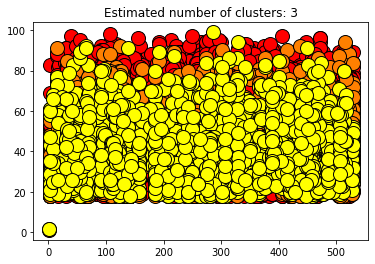

In [124]:
labels_true = df_acp.iloc[:,0]
X = StandardScaler().fit_transform(df_acp)

print('Estimated number of clusters: %d' % n_clusters_)
#print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true,clusters2))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true,clusters2))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true,clusters2))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, clusters2))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true,clusters2,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, clusters2))


# Black removed and is used for noise instead.
unique_labels = set(clusters2)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (clusters2 == k)
    cluster_center = cluster_centers[k]

    xy = df_acp[class_member_mask]
    plt.plot(xy.iloc[:, 2], xy.iloc[:, 3], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()